# Clustering Project Notebook
***

## Zillow: What is driving the errors in the Zestimates?

### Background:

Zillow, a real estate website in the United States, uses a Zestimate to estimate a property's market value.

"The Zestimate® home valuation model is Zillow’s estimate of a home’s market value. A Zestimate incorporates public, MLS and user-submitted data into Zillow’s proprietary formula, also taking into account home facts, location and market trends. It is not an appraisal and can’t be used in place of an appraisal." - zillow.com

For this project, we will look into finding drivers of error in the Zestimate.  Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error.  


### Project Goals:

- Using Zillow data for single unit/single family homes sold in 2017, find drivers of log error in the Zestimate.

- Create 4 regression models to predict log error

- Use clustering methodologies to help identify drivers of log error

- Deliver findings in a final Jupyter Notebook presentation


## Executive Summary: 

#### Findings Include:


#### Takeaways:


#### Next Steps to Explore Further:

***

# Data Acquisition / Data Preparation / Wrangling

##### Using custom functions in wrangle.py, use an SQl query to pull data from Zillow database joining 7 tables to select only properties sold in 2017 for single unit / single family homes.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_excs as wrangle

In [2]:
df = wrangle.wrangle_zillow()

### Data Acquisition / Prep / Wrangling Takeaways:

- Created and used functions in wrangle.py to acquire and prep data

- Used a SQL query to join 7 tables
- Selected only single family properties filtered by:
    - Properties with propertylandusetypeid = [261, 262, 263, 264, 265, 266, 279]
    - Only retrieving latest transaction date, eliminating duplicates sold more than once in same year
    - Only selecting properties with at least 1 bath & bed and 350 sqft area 
    - Only properties with a latitude and longitude that is not null
    - Dropping columns that are less than 70% populated, mostly empty columns
    - Adding a 'county' column based on FIPS unique county identifier feature
    - Dropping columns that are not useful features or redundant
    - Filling null values in unitcnt column with 1 since all are single unit properties
    - Replacing nulls with median values for select columns: 
        - 7313 for lotsizesquarefeet
        - 6.0 for buildingqualitytypeid
    -Since this is Southern CA, filling null with 'None' for heatingorsystemdesc because most likely don't have one
    -Rename columns for easier readability
    -Removed outliers based on Inter Quartile Rule for properties with outliers in square footage, price, bedrooms, and bathrooms
    



# Explore

In [3]:
# Take a look at the dataframe returned from acquire & prep after wrangling
df.shape

(67490, 25)

In [4]:
df.head()

,bathrooms,bedrooms,buildingqualitytypeid,sq_footage,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county
0,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,...,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01,None,Single Family Residential,Orange
1,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,...,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,None,Single Family Residential,Ventura
2,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,...,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,None,Single Family Residential,Orange
3,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles
4,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,12447.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01,Central,Condominium,Los Angeles


In [5]:
#Check to see if nulls were removed
wrangle.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
bathrooms,0,0.0
bedrooms,0,0.0
buildingqualitytypeid,0,0.0
sq_footage,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0
lotsizesquarefeet,0,0.0
rawcensustractandblock,0,0.0
regionidcity,0,0.0


In [6]:
wrangle.nulls_by_row(df)

,num_cols_missing,percent_cols_missing,index
0,0,0.0,67490


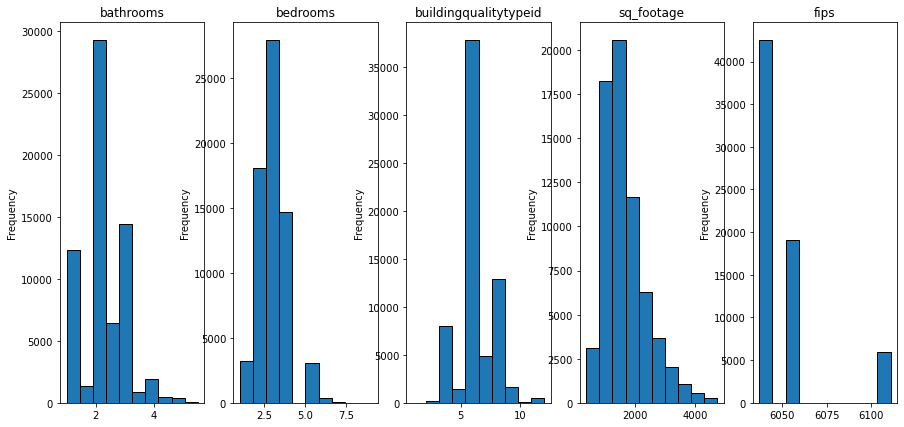

In [8]:
# Plot the distribution of some numeric variables
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

In [9]:
#Binning square footage for comparison and visualization purposes
df['sq_footage_bins'] = pd.cut(df.sq_footage, [0, 1000, 2000,3000,4000, 10000])
df.head()

,bathrooms,bedrooms,buildingqualitytypeid,sq_footage,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,sq_footage_bins
0,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,...,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01,None,Single Family Residential,Orange,"(3000, 4000]"
1,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,...,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,None,Single Family Residential,Ventura,"(1000, 2000]"
2,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,...,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,None,Single Family Residential,Orange,"(1000, 2000]"
3,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,...,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles,"(2000, 3000]"
4,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,12447.0,...,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01,Central,Condominium,Los Angeles,"(1000, 2000]"


In [11]:
df['transactiondate'] = pd.to_datetime(df['transactiondate'])
df['month'] = pd.DatetimeIndex(df['transactiondate']).month
df.head()

,bathrooms,bedrooms,buildingqualitytypeid,sq_footage,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,sq_footage_bins,month
0,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,...,2016.0,537569.0,11013.72,0.025595,2017-01-01,None,Single Family Residential,Orange,"(3000, 4000]",1
1,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,...,2016.0,376000.0,5672.48,0.055619,2017-01-01,None,Single Family Residential,Ventura,"(1000, 2000]",1
2,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,...,2016.0,479489.0,6488.30,0.005383,2017-01-01,None,Single Family Residential,Orange,"(1000, 2000]",1
3,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,...,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles,"(2000, 3000]",1
4,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,12447.0,...,2016.0,45726.0,1533.89,0.006940,2017-01-01,Central,Condominium,Los Angeles,"(1000, 2000]",1


In [12]:
#Binning transactiondate for comparison and visualization purposes
df['month_bins'] = pd.cut(df.month, [0,3,6,9,12])
df.head()

,bathrooms,bedrooms,buildingqualitytypeid,sq_footage,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,sq_footage_bins,month,month_bins
0,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,...,537569.0,11013.72,0.025595,2017-01-01,None,Single Family Residential,Orange,"(3000, 4000]",1,"(0, 3]"
1,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,...,376000.0,5672.48,0.055619,2017-01-01,None,Single Family Residential,Ventura,"(1000, 2000]",1,"(0, 3]"
2,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,...,479489.0,6488.30,0.005383,2017-01-01,None,Single Family Residential,Orange,"(1000, 2000]",1,"(0, 3]"
3,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,...,36225.0,1777.51,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles,"(2000, 3000]",1,"(0, 3]"
4,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,12447.0,...,45726.0,1533.89,0.006940,2017-01-01,Central,Condominium,Los Angeles,"(1000, 2000]",1,"(0, 3]"


(-4.0, 4.0)

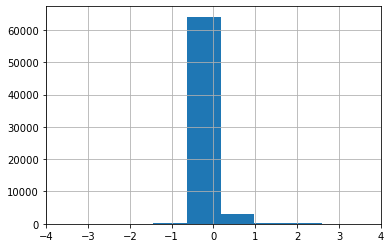

In [21]:
#Look at logerror
df.logerror.hist()
plt.xlim(-4, 4)

In [19]:
df.logerror.max(), df.logerror.min(), df.logerror.mean(), df.logerror.median()

(3.39454406516, -4.65542037764, 0.016190522976922635, 0.00618658543751)

In [22]:
df.buildingqualitytypeid.value_counts()

6.0     37816
8.0     12896
4.0      8063
7.0      4905
9.0      1605
5.0      1468
11.0      479
3.0       142
10.0       80
12.0       28
1.0         5
2.0         3
Name: buildingqualitytypeid, dtype: int64

### Before exploring data further, will need to split data into train, validate and test so that we only explore on train.

In [13]:
train, validate, test = wrangle.train_validate_test_split(df)
train.shape, validate.shape, test.shape

((40494, 28), (13498, 28), (13498, 28))

### Question 1.  Does log error differ across square feet?

<AxesSubplot:title={'center':'Is there a relationship between logerror and square feet?'}, xlabel='logerror', ylabel='sq_footage'>

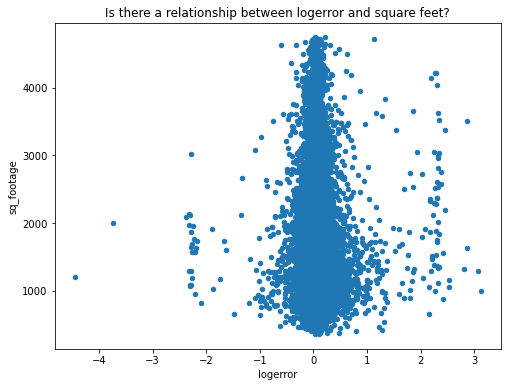

In [23]:
#Let's look at the relationship between log error and square feet
train.plot.scatter(
    x="logerror",
    y="sq_footage",
    title='Is there a relationship between logerror and square feet?',
    figsize=(8, 6),
)

<AxesSubplot:>

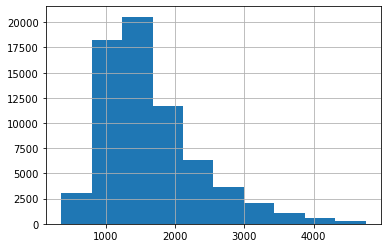

In [24]:
#Let's look at the distribution of square footage 
df.sq_footage.hist()

<AxesSubplot:title={'center':'Distribution of sq_footage_bin'}>

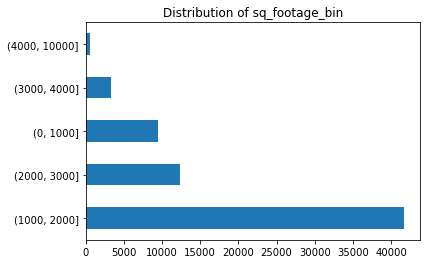

In [25]:
#Let's look at the distribution of square footage by bins
#Looks like most properties are between 1,000-2,000 square feet

df.sq_footage_bins.value_counts().plot.barh(title='Distribution of sq_footage_bin')

<AxesSubplot:xlabel='sq_footage_bins', ylabel='logerror'>

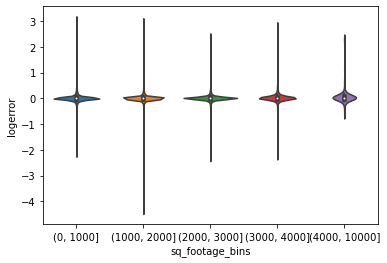

In [26]:
#Let's look at how log error compares across square footage by bins
#It doesn't look like there's much difference 
sns.violinplot(data=train, y='logerror', x='sq_footage_bins')

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the square footage

$H_a$: there is a difference in logerror variance between the square footage

In [27]:
stats.levene(
    train[train.sq_footage <= 1000].logerror,
    train[train.sq_footage > 1000].logerror,
)

LeveneResult(statistic=26.421381823118583, pvalue=2.7575885155652377e-07)

In [28]:
stats.levene(
    train[train.sq_footage <= 2000].logerror,
    train[train.sq_footage > 2000].logerror,
)

LeveneResult(statistic=0.9133570477417297, pvalue=0.339230966900938)

In [29]:
stats.levene(
    train[train.sq_footage <= 3000].logerror,
    train[train.sq_footage > 3000].logerror,
)

LeveneResult(statistic=33.21175253136165, pvalue=8.32476642871702e-09)

In [30]:
stats.levene(
    train[train.sq_footage <= 4000].logerror,
    train[train.sq_footage > 4000].logerror,
)

LeveneResult(statistic=26.208966386291532, pvalue=3.077963100113169e-07)

#### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all square footages.
The variance is not equal.

### Create independent statistical tests to check for dependency amongst variables

In [32]:
stats.ttest_ind(
    train[train.sq_footage <= 1000].logerror,
    train[train.sq_footage > 1000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-1.1795354395250444, pvalue=0.23822231653253545)

In [33]:
stats.ttest_ind(
    train[train.sq_footage <= 2000].logerror,
    train[train.sq_footage > 2000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.468852786673966, pvalue=4.6028033991275334e-08)

In [34]:
stats.ttest_ind(
    train[train.sq_footage <= 3000].logerror,
    train[train.sq_footage > 3000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.288640220586799, pvalue=1.3446342217119166e-07)

In [35]:
stats.ttest_ind(
    train[train.sq_footage <= 4000].logerror,
    train[train.sq_footage > 4000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.2396298227168385, pvalue=0.0013143037052781863)

### Conclusion:
We reject the null hypothesis that the logerror is the same for square footages above 1000 square feet.

### Question 2. Does  log error differ across county?

In [38]:
#Look at how counties compare in number
df.county.value_counts()

Los Angeles    42474
Orange         19108
Ventura         5908
Name: county, dtype: int64

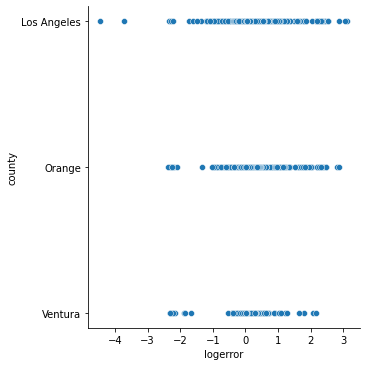

In [40]:
#Look at how log error compares amongst counties
sns.relplot(data=train, x='logerror', y='county')

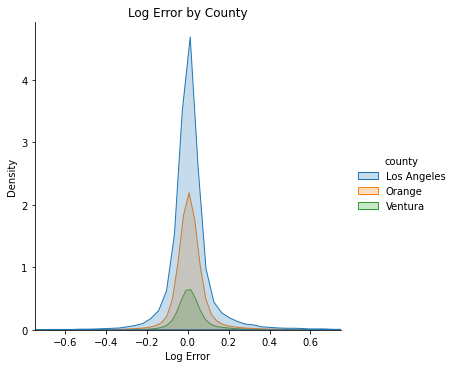

In [41]:
#Plotting distribution of log error by county

sns.displot(train, x='logerror', hue='county', kind='kde', fill=True)
plt.title('Log Error by County')
plt.xlabel('Log Error')
plt.xlim(-0.75, 0.75)
plt.show()

#### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the counties
 
𝐻𝑎 : there is a difference in logerror variance between the counties

In [42]:
stats.levene(
    train[train.county == 'Los Angeles'].logerror,
    train[train.county != 'Los Angeles'].logerror,
)

LeveneResult(statistic=25.420357603593807, pvalue=4.630126029827358e-07)

In [43]:
stats.levene(
    train[train.county == 'Ventura'].logerror,
    train[train.county != 'Ventura'].logerror,
)

LeveneResult(statistic=13.435255590635176, pvalue=0.0002472547032054955)

In [44]:
stats.levene(
    train[train.county == 'Orange'].logerror,
    train[train.county != 'Orange'].logerror,
)

LeveneResult(statistic=9.66021727850087, pvalue=0.0018843171405163632)

### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all counties.
The variance is not equal.

In [46]:
#Running a T-Test to check if county is independent of log error
stats.ttest_ind(
    df.query('county == "Los Angeles"').logerror,
    df.query('county == "Orange"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.690124587002322, pvalue=0.0002245156221965261)

In [47]:
stats.ttest_ind(
    df.query('county == "Ventura"').logerror,
    df.query('county == "Orange"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-2.0580613382754938, pvalue=0.03960587164470629)

In [48]:
stats.ttest_ind(
    df.query('county == "Los Angeles"').logerror,
    df.query('county == "Ventura"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-0.38916233430025177, pvalue=0.6971666541218813)

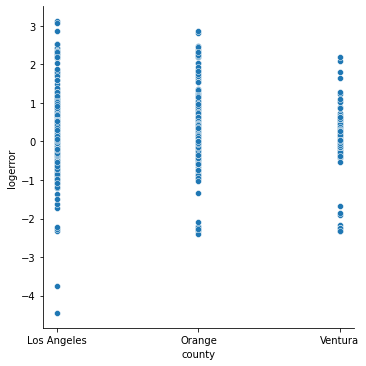

In [49]:
sns.relplot(data=train, y='logerror', x='county')

### Conclusion:
We reject the null hypothesis that the logerror is the same for all counties.

### Question 3. Does  log error differ across transaction date?

<AxesSubplot:title={'center':'Is there a relationship between logerror and transaction date?'}, xlabel='transactiondate', ylabel='logerror'>

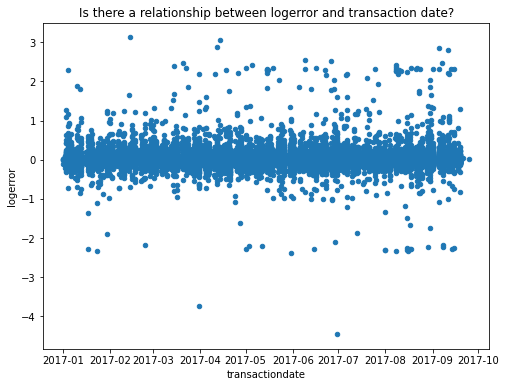

In [50]:
train.plot.scatter(
    y="logerror",
    x="transactiondate",
    title='Is there a relationship between logerror and transaction date?',
    figsize=(8, 6),
)

<AxesSubplot:>

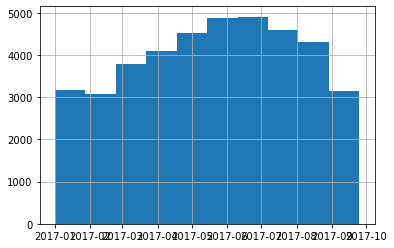

In [51]:
train.transactiondate.hist()

In [52]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['month'] = pd.DatetimeIndex(train['transactiondate']).month
train.head()

,bathrooms,bedrooms,buildingqualitytypeid,sq_footage,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,sq_footage_bins,month,month_bins
6378,1.0,3.0,4.0,1368.0,6037.0,34174813.0,-118512540.0,5899.0,6.037139e+07,12447.0,...,414357.0,6417.40,0.211513,2017-01-30,Floor/Wall,Single Family Residential,Los Angeles,"(1000, 2000]",1,"(0, 3]"
65133,2.0,4.0,8.0,2381.0,6037.0,34536607.0,-118049605.0,39349.0,6.037911e+07,40227.0,...,122000.0,4191.95,0.018574,2017-08-10,Central,Single Family Residential,Los Angeles,"(2000, 3000]",8,"(6, 9]"
45602,2.0,3.0,6.0,1810.0,6037.0,33824560.0,-118270268.0,5604.0,6.037544e+07,10723.0,...,383000.0,6349.38,0.017428,2017-06-13,Floor/Wall,Single Family Residential,Los Angeles,"(1000, 2000]",6,"(3, 6]"
75623,2.0,4.0,6.0,1558.0,6059.0,33791770.0,-118068568.0,8255.0,6.059110e+07,46314.0,...,30142.0,1235.08,0.037663,2017-09-12,None,Single Family Residential,Orange,"(1000, 2000]",9,"(6, 9]"
71792,2.0,4.0,6.0,1769.0,6111.0,34265339.0,-118798087.0,8090.0,6.111008e+07,27110.0,...,359000.0,6301.48,0.029618,2017-08-30,None,Single Family Residential,Ventura,"(1000, 2000]",8,"(6, 9]"


<AxesSubplot:title={'center':'Distribution of month_bin'}>

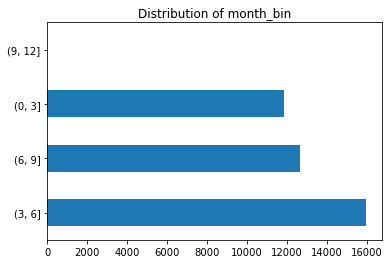

In [53]:
train.month_bins.value_counts().plot.barh(title='Distribution of month_bin')

<AxesSubplot:xlabel='month_bins', ylabel='logerror'>

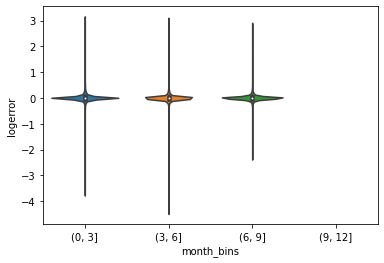

In [54]:
sns.violinplot(data=train, y='logerror', x='month_bins')

<AxesSubplot:title={'center':'Is there a relationship between logerror and month?'}, xlabel='month', ylabel='logerror'>

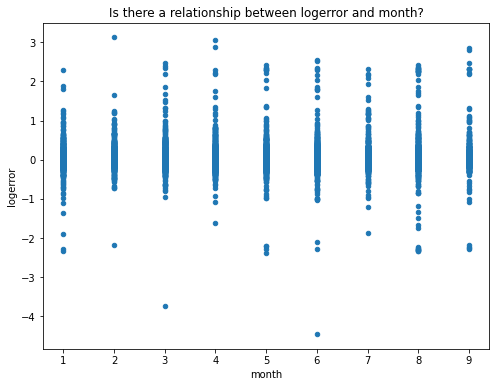

In [55]:
train.plot.scatter(
    y="logerror",
    x="month",
    title='Is there a relationship between logerror and month?',
    figsize=(8, 6),
)

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the transaction months before and after June

$H_a$: there is a difference in logerror variance between the transaction months before and after June

In [56]:
stats.levene(
    train[train.month <= 6].logerror,
    train[train.month > 6].logerror,
)

LeveneResult(statistic=0.23020178079501571, pvalue=0.6313768429384812)

In [57]:
# We fail to reject the null hypothesis that there is no difference in logerror variance between the 
#transaction months before and after June.  The variance is equal. 

### Are the log error and the month of the transaction independent of each other?

$H_0$ : The log error for sales in or before June is the same that logerror for sales after June.

$H_a$ : The log error for sales in or before June is the not same that logerror for sales after June.

In [58]:
stats.ttest_ind(
   train[train.month <= 6].logerror,
    train[train.month > 6].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-2.7771286250995333, pvalue=0.005486668073244086)

### Conclusion:
We reject the null hypothesis that the log error for sales in or before June is the same that log error for sales after June. The logerror for sales in or before June is the same that logerror for sales after June.

### Question 4.  If we control for month, does log error differ across county?
1. Viz logerror by county for each month bin

2. Analyze each month bin separately

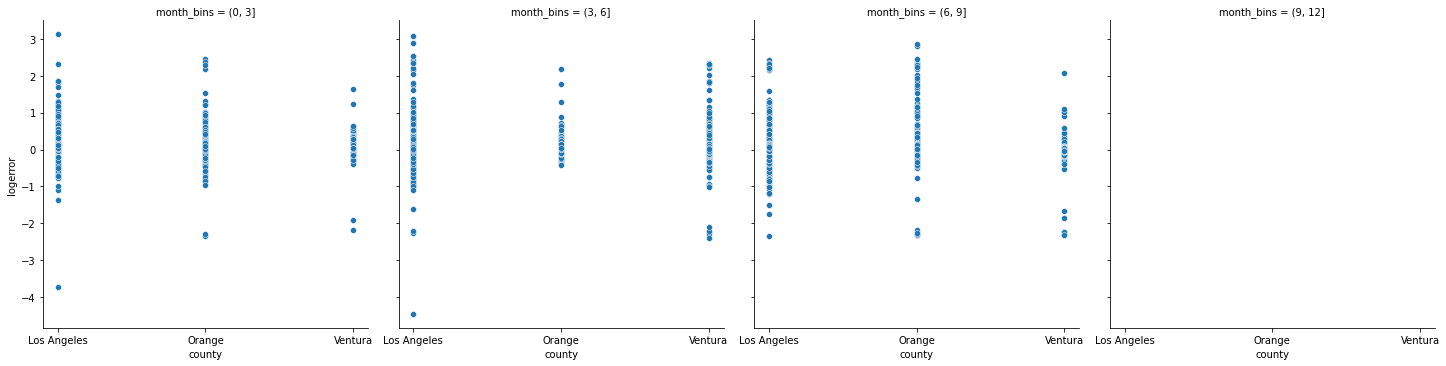

In [59]:
sns.relplot(data=train, y='logerror', x='county', col='month_bins')

In [60]:
# Logerror does not seem to vary much by month or county

Text(0.5, 1.0, 'Does county acccount for upper vs lower\nlogerror in square footage for sales before July?')

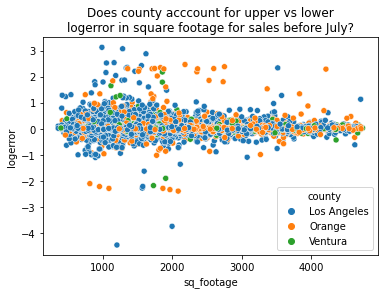

In [61]:
sns.scatterplot(
    x='sq_footage',
    y='logerror',
    data=train[train.month <= 6],
    hue='county',
)
plt.title("Does county acccount for upper vs lower\nlogerror in square footage for sales before July?")

In [62]:
# For sales before July 1st, log error may be grouped by county where Orange County and LA County have higher errors.

Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror in the square footage?')

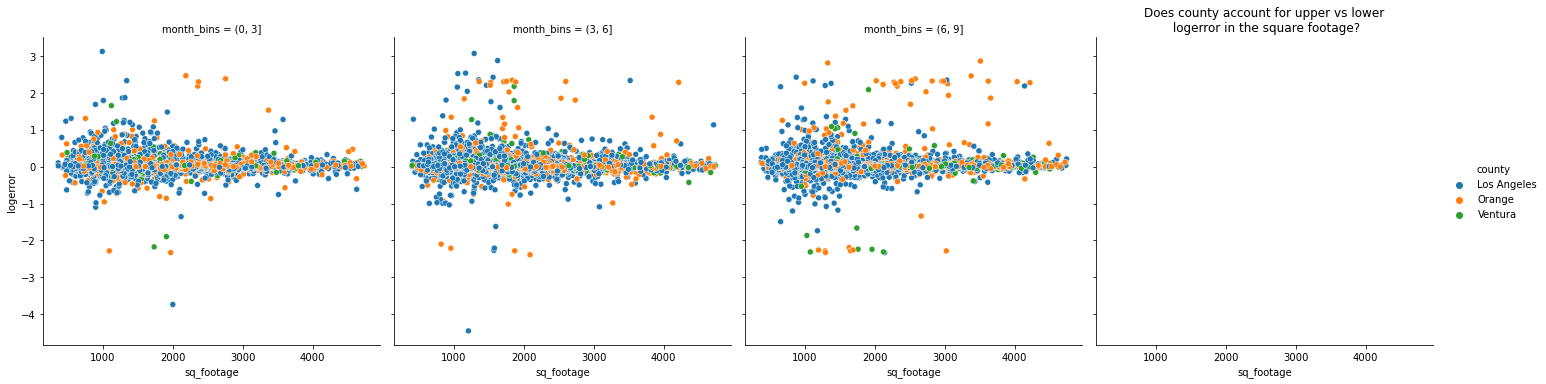

In [63]:
sns.relplot(
    x='sq_footage',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?")

In [ ]:
# Orange County seems to have higher log errors compared to the other counties, 
#especially during the months of June-Sept.  Los Angeles couny looks to have more variance in error, being more 
#scattered on both sides of 0. 


Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror in the square footage?')

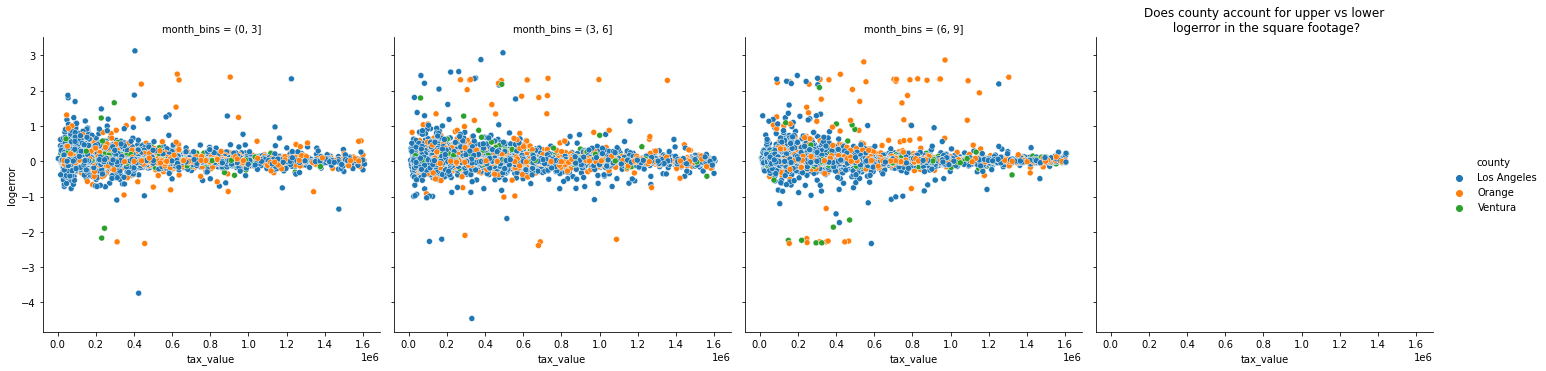

In [64]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?")

In [65]:
#Comparing using tax value, Orange County still seems to have the highest log errors, especially during June-Sept

Text(0.5, 1.0, 'Does county account for upper vs lower\n log error in the price of property?')

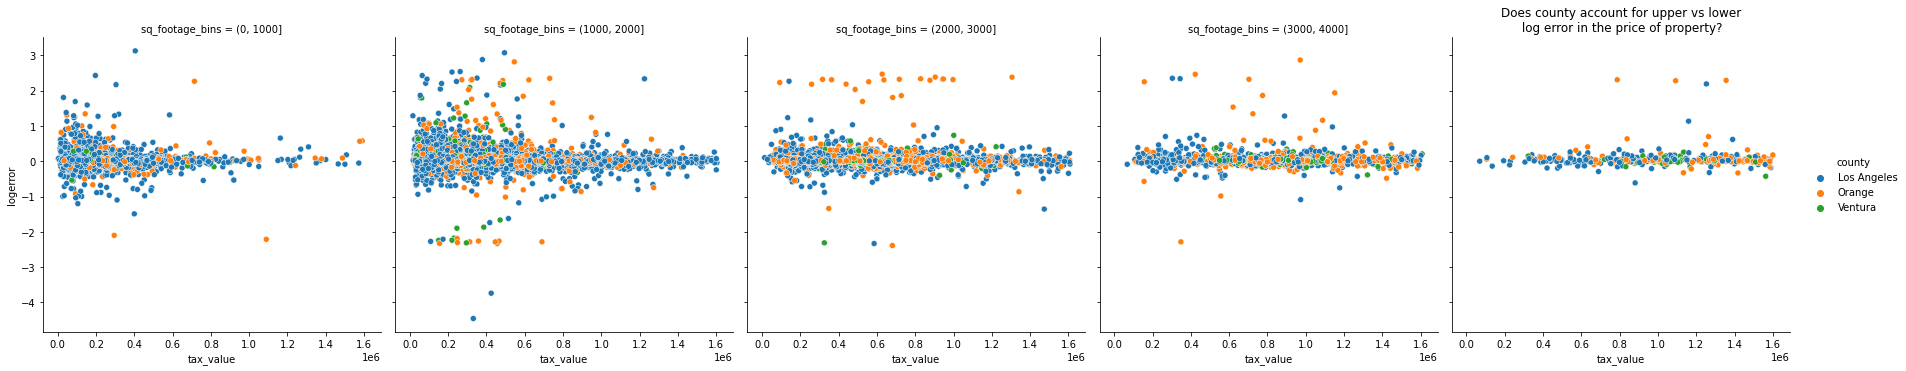

In [67]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='sq_footage_bins',
)

plt.title("Does county account for upper vs lower\n log error in the price of property?")

In [ ]:
#Comparing using tax value, Orange County accounts for most of the upper band seen in the log error (higher log error)
# especially for homes between 2,000-3,000 square feet.

In [68]:
# Overall, county does seem to be grouped together for certain months and certain square footage

In [69]:
#Let's look at how variables are correlated
corr =  train.corr(method='pearson')

<AxesSubplot:>

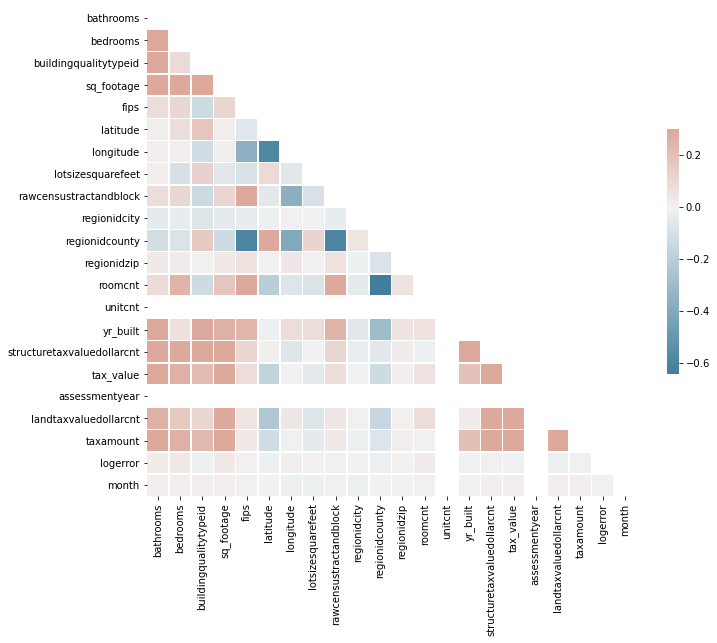

In [70]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [71]:
corr_log = train.corrwith(train["logerror"])
corr_log.max

<bound method NDFrame._add_numeric_operations.<locals>.max of bathrooms                     0.027558
bedrooms                      0.035392
buildingqualitytypeid        -0.013531
sq_footage                    0.036798
fips                          0.006574
latitude                     -0.011984
longitude                     0.015879
lotsizesquarefeet             0.007544
rawcensustractandblock        0.006598
regionidcity                 -0.002021
regionidcounty               -0.017465
regionidzip                   0.002730
roomcnt                       0.020787
unitcnt                            NaN
yr_built                      0.004309
structuretaxvaluedollarcnt    0.006424
tax_value                    -0.006590
assessmentyear                     NaN
landtaxvaluedollarcnt        -0.012332
taxamount                    -0.007145
logerror                      1.000000
month                         0.001169
dtype: float64>

In [72]:
print(corr_log.sort_values(ascending=False))

logerror                      1.000000
sq_footage                    0.036798
bedrooms                      0.035392
bathrooms                     0.027558
roomcnt                       0.020787
longitude                     0.015879
lotsizesquarefeet             0.007544
rawcensustractandblock        0.006598
fips                          0.006574
structuretaxvaluedollarcnt    0.006424
yr_built                      0.004309
regionidzip                   0.002730
month                         0.001169
regionidcity                 -0.002021
tax_value                    -0.006590
taxamount                    -0.007145
latitude                     -0.011984
landtaxvaluedollarcnt        -0.012332
buildingqualitytypeid        -0.013531
regionidcounty               -0.017465
unitcnt                            NaN
assessmentyear                     NaN
dtype: float64


In [73]:
#When looking at correlation with log error, square footage, bedrooms, and bathrooms rank highest.

### Question 5: Does log error differ for different number of bedrooms?

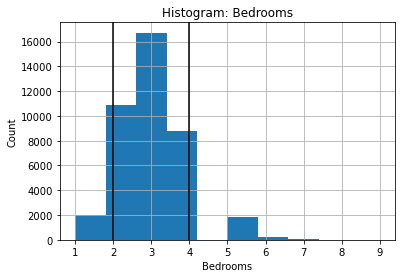

In [74]:
ax = train.bedrooms.hist()
plt.title('Histogram: Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
ax.axvline(2, color='black')
ax.axvline(4, color='black')



<AxesSubplot:title={'center':'Is there a relationship between log error and bedrooms?'}, xlabel='bedrooms', ylabel='logerror'>

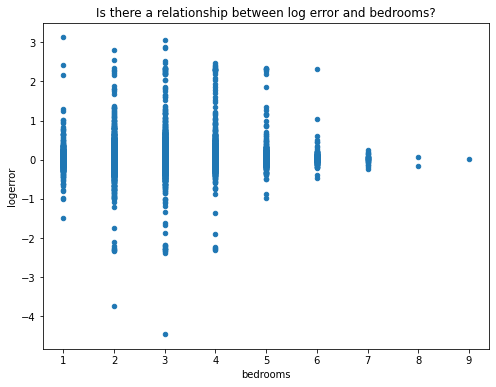

In [75]:
train.plot.scatter(
    y="logerror",
    x="bedrooms",
    title='Is there a relationship between log error and bedrooms?',
    figsize=(8, 6),
)

<AxesSubplot:xlabel='bedrooms', ylabel='logerror'>

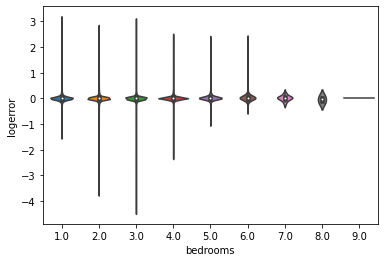

In [76]:
sns.violinplot(data=train, y='logerror', x='bedrooms')

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance for different number of bedrooms

$H_a$: there is a difference in logerror variance different number of bedrooms

In [77]:
stats.levene(
    train[train.bedrooms <= 5].logerror,
    train[train.month > 5].logerror,
)

LeveneResult(statistic=0.052954660926955895, pvalue=0.8180002577359538)

In [78]:
# We fail to reject the null hypothesis that there is no difference in logerror variance for different number of bedrooms.
#The variance is equal

### Is the log error the same for properties with  4 or less as those with more than 4 bedrooms?

$H_0$ : The logerror is the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms.

$H_a$ : The logerror is not the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms.

In [80]:
stats.ttest_ind(
   train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-6.256198579620443, pvalue=3.984111118952614e-10)

### Conclusion:
We reject the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than  bedrooms.

Text(0.5, 1.0, 'Does log error depend on number of bedrooms?')

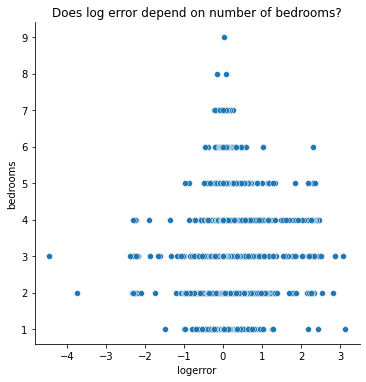

In [82]:
sns.relplot(
    y='bedrooms',
    x='logerror',
    data=train,
)
plt.title("Does log error depend on number of bedrooms?")